In [1]:
# =========================
# 0. Imports & Settings
# =========================
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

sns.set(style="whitegrid", rc={"figure.dpi": 120})
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Folder where Kaggle lets you download files from
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
# =========================
# 1. Load Dataset (robust path)
# =========================
# Common Kaggle path for this dataset:
default_path = "/kaggle/input/creditcardfraud/creditcard.csv"

if os.path.exists(default_path):
    data_path = default_path
else:
    # Try to find the csv anywhere under /kaggle/input
    matches = glob.glob("/kaggle/input/**/creditcard.csv", recursive=True)
    data_path = matches[0] if matches else "creditcard.csv"  # last fallback

print("Loading:", data_path)
df = pd.read_csv(data_path)
print(df.shape)
df.head()


Loading: /kaggle/input/credit-card-fraud-detection-data-set/creditcard.csv
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# =========================
# 2. Quick Data Check
# =========================
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nClass distribution (0=legit, 1=fraud):\n", df['Class'].value_counts())
print("\nClass distribution (%):\n", df['Class'].value_counts(normalize=True).round(4)*100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# =========================
# 3. Data Cleaning
# =========================
# Drop exact duplicate rows (rare)
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped duplicates: {before - after}")

# Ensure numeric types are correct (they should be already)
numeric_cols = df.columns.tolist()  # all are numeric in this dataset
# Handle any missing values (should be none)
df = df.dropna().reset_index(drop=True)

print("Cleaned shape:", df.shape)


Dropped duplicates: 1081
Cleaned shape: (283726, 31)


In [5]:
# =========================
# 3. Data Cleaning
# =========================
# Drop exact duplicate rows (rare)
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped duplicates: {before - after}")

# Ensure numeric types are correct (they should be already)
numeric_cols = df.columns.tolist()  # all are numeric in this dataset
# Handle any missing values (should be none)
df = df.dropna().reset_index(drop=True)

print("Cleaned shape:", df.shape)


Dropped duplicates: 0
Cleaned shape: (283726, 31)


In [6]:
# =========================
# 4. Feature Engineering
# =========================
# Time is seconds since first transaction — derive Hour of day
df['Hour'] = (df['Time'] // 3600) % 24

# Amount buckets (analyst-friendly feature)
df['AmountBucket'] = pd.cut(
    df['Amount'],
    bins=[-0.01, 50, 200, 1000, df['Amount'].max()+1],
    labels=['small', 'medium', 'large', 'very_large']
)

# (Optional) Scaled amount for modeling
scaler = StandardScaler()
df['AmountScaled'] = scaler.fit_transform(df[['Amount']])

# Save a CLEAN analyst-friendly dataset (without scaled column if you prefer)
df_clean = df.copy()
df_clean.to_csv(f"{OUTPUT_DIR}/cleaned_creditcard.csv", index=False)
print("✅ Saved cleaned dataset ->", f"{OUTPUT_DIR}/cleaned_creditcard.csv")


✅ Saved cleaned dataset -> /kaggle/working/cleaned_creditcard.csv


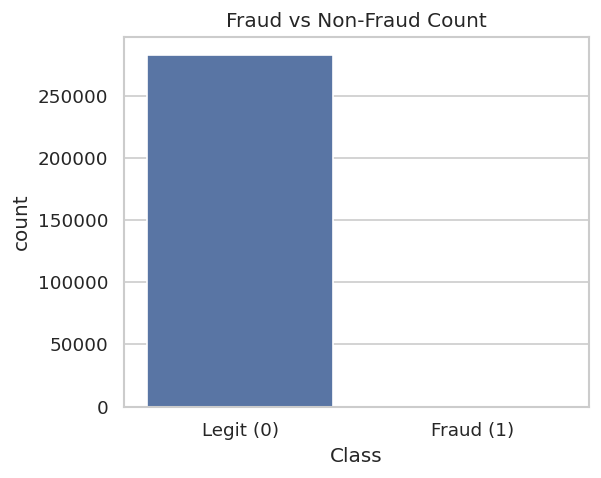

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

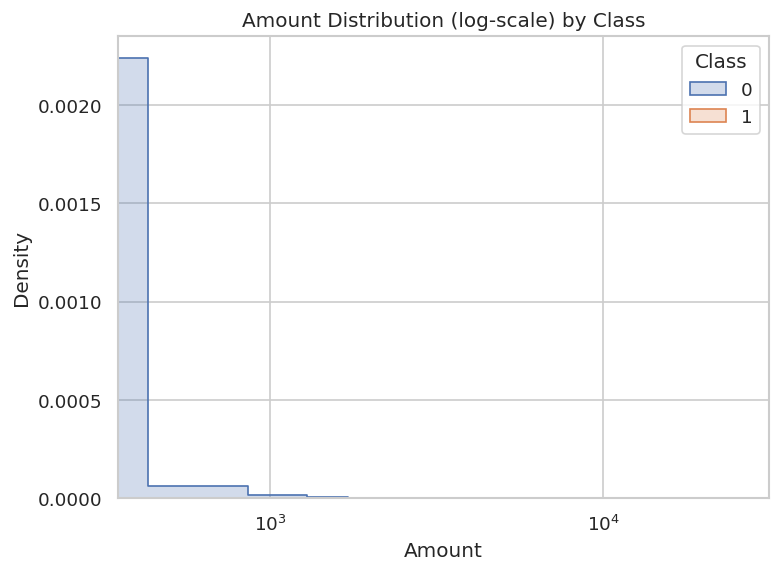

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

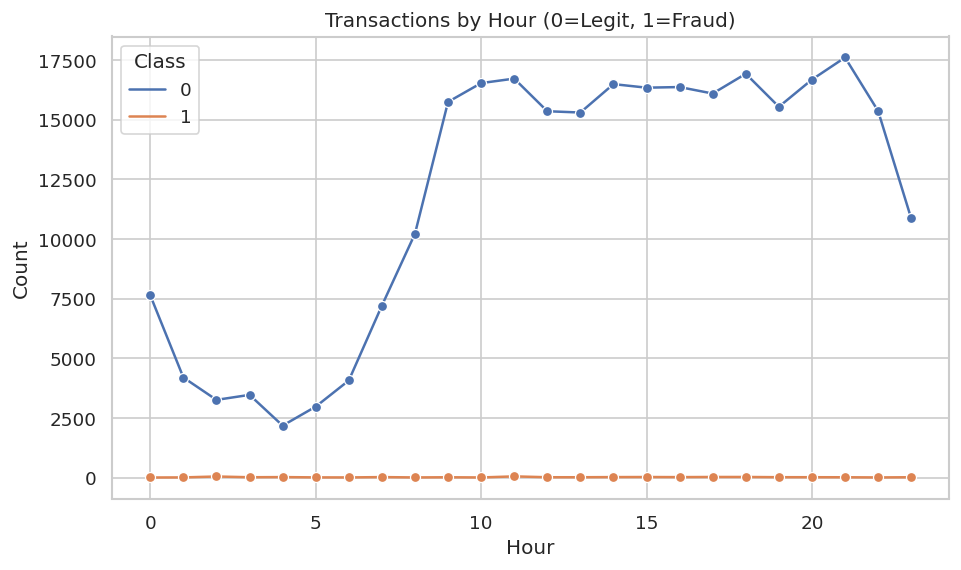

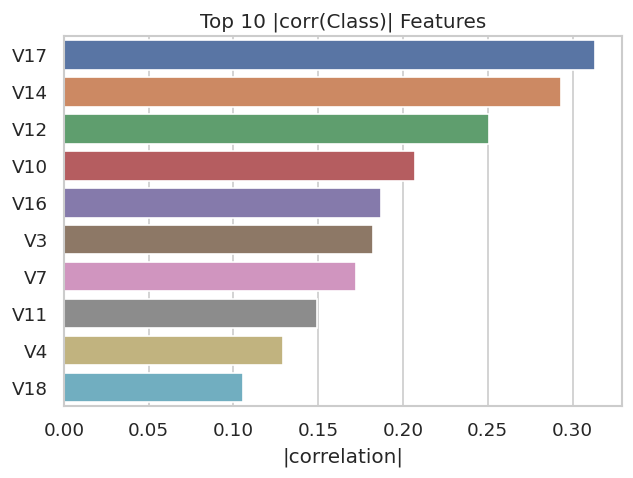

✅ Saved plots to /kaggle/working:
 - class_distribution.png
 - amount_distribution_by_class.png
 - transactions_by_hour.png
 - top_corr_with_class.png


In [7]:
# =========================
# 5A. Class distribution
# =========================
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Count")
plt.xticks([0,1], ['Legit (0)', 'Fraud (1)'])
plt.savefig(f"{OUTPUT_DIR}/class_distribution.png", bbox_inches="tight")
plt.show()

# =========================
# 5B. Amount distribution by class (log scale)
# =========================
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='Amount', hue='Class', bins=60, element='step', stat='density')
plt.yscale('linear')
plt.xscale('log')  # fraud amounts vary; log scale helps
plt.title("Amount Distribution (log-scale) by Class")
plt.savefig(f"{OUTPUT_DIR}/amount_distribution_by_class.png", bbox_inches="tight")
plt.show()

# =========================
# 5C. Transactions by Hour (class-wise)
# =========================
by_hour = df.groupby(['Hour','Class']).size().reset_index(name='Count')
plt.figure(figsize=(9,5))
sns.lineplot(data=by_hour, x='Hour', y='Count', hue='Class', marker='o')
plt.title("Transactions by Hour (0=Legit, 1=Fraud)")
plt.savefig(f"{OUTPUT_DIR}/transactions_by_hour.png", bbox_inches="tight")
plt.show()

# =========================
# 5D. Top features correlated with Class
# =========================
corr = df.corr(numeric_only=True)['Class'].drop('Class').abs().sort_values(ascending=False)
top10 = corr.head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=top10.values, y=top10.index)
plt.title("Top 10 |corr(Class)| Features")
plt.xlabel("|correlation|")
plt.savefig(f"{OUTPUT_DIR}/top_corr_with_class.png", bbox_inches="tight")
plt.show()

print("✅ Saved plots to /kaggle/working:")
for fn in ["class_distribution.png", "amount_distribution_by_class.png", "transactions_by_hour.png", "top_corr_with_class.png"]:
    print(" -", fn)


In [8]:
# =========================
# 6. Train/Test Split
# =========================
# Use V1..V28 + AmountScaled + Hour as features
feature_cols = [c for c in df.columns if c.startswith('V')] + ['AmountScaled', 'Hour']
X = df[feature_cols].values
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Fraud % in train:", (y_train.mean()*100).round(4), "% | test:", (y_test.mean()*100).round(4), "%")


Train shape: (226980, 30)  Test shape: (56746, 30)
Fraud % in train: 0.1665 % | test: 0.1674 %


In [9]:
# =========================
# 7. Logistic Regression (class_weight='balanced')
# =========================
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=200,
    n_jobs=None,       # (param removed in new sklearn; keep default)
    solver='lbfgs',
    random_state=RANDOM_STATE
)
logreg.fit(X_train, y_train)

proba_lr = logreg.predict_proba(X_test)[:,1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("LogReg AUC:", roc_auc_score(y_test, proba_lr).round(4))
print("\nClassification Report (LogReg):\n", classification_report(y_test, pred_lr, digits=4))
print("Confusion Matrix (LogReg):\n", confusion_matrix(y_test, pred_lr))


LogReg AUC: 0.9656

Classification Report (LogReg):
               precision    recall  f1-score   support

           0     0.9998    0.9751    0.9873     56651
           1     0.0556    0.8737    0.1045        95

    accuracy                         0.9749     56746
   macro avg     0.5277    0.9244    0.5459     56746
weighted avg     0.9982    0.9749    0.9858     56746

Confusion Matrix (LogReg):
 [[55240  1411]
 [   12    83]]


In [ ]:
# =========================
# 8. Random Forest (class_weight='balanced')
# =========================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:,1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("RF AUC:", roc_auc_score(y_test, proba_rf).round(4))
print("\nClassification Report (RF):\n", classification_report(y_test, pred_rf, digits=4))
print("Confusion Matrix (RF):\n", confusion_matrix(y_test, pred_rf))


In [ ]:
# =========================
# 9. ROC Curves
# =========================
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_score(y_test, proba_lr):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_score(y_test, proba_rf):.3f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png", bbox_inches="tight")
plt.show()

print("✅ Saved ROC curve ->", f"{OUTPUT_DIR}/roc_curves.png")


In [ ]:
# =========================
# 11. Save Key Metrics & Notes
# =========================
results = {
    "logreg_auc": float(roc_auc_score(y_test, proba_lr)),
    "rf_auc": float(roc_auc_score(y_test, proba_rf)),
    "train_rows": int(X_train.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "fraud_pct_train": float(y_train.mean()),
    "fraud_pct_test": float(y_test.mean()),
    "features": feature_cols
}
with open(f"{OUTPUT_DIR}/metrics.json", "w") as f:
    json.dump(results, f, indent=2)

print("✅ Saved metrics.json ->", f"{OUTPUT_DIR}/metrics.json")
print("📂 Download from right panel: /kaggle/working/")
